<a href="https://colab.research.google.com/github/R12942159/DeepLearning/blob/main/DLCV_hw1_scratch_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

{0: bike, 1: chair, 2: camel, 3: rabbit, 4: lamp, 5: clock,
6: tree?, 7: fox, 8: hedgehog, 9: bed, 10: child,
11: Dinosaur, 12: building, 13: tree?, 14: apple, 15: animal?,
16: animal?, 17: kangaroo, 18: tree?, 19: snake, 20: beetle,
21: cupboard, 22: mouse, 23: tree?, 24: house, 25: Wolf}

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch


# Get cuda from GPU device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


In [2]:
# search file paths
from glob import glob


img_paths_train = glob('/content/drive/MyDrive/NTU_DLCV/p1_data/train_50/*.png') # *: all
img_paths_train = glob('/content/drive/MyDrive/NTU_DLCV/p1_data/train_50/*.png') # *: all
img_paths_val = glob('/content/drive/MyDrive/NTU_DLCV/p1_data/val_50/*.png')

In [3]:
# number of images
len(img_paths_train), len(img_paths_val)

(22500, 2500)

In [4]:
import torch
import cv2


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size):
        self.img_paths = img_paths
        self.img_size = img_size

    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        """read 1 sample"""
        # Read img
        path = self.img_paths[idx] # get img path
        img = cv2.imread(path) # read img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
        img = cv2.resize(img, (self.img_size, self.img_size)) # Resize iamge
        img = img / 255.0 # 0~255 -> 0.~1.

        # Read class index
        cls_idx = int((path.split('/')[-1]).split('_')[0])

        # transform img to tensor
        img = torch.tensor(img, dtype=torch.float)
        img = img.permute(2, 0, 1) # (H, W, C) -> (C, H, W)
        cls_idx = torch.tensor(cls_idx, dtype=torch.long)

        return img, cls_idx

In [5]:
# Build dataset
IMG_SIZE = 32
train_ds = MyDataset(img_paths_train, IMG_SIZE)
val_ds = MyDataset(img_paths_val, IMG_SIZE)

In [6]:
# Build DataLoaders
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

In [7]:
# Define Model class
from torch import nn
import torchvision
from torchsummary import summary # model summary


class CNN_scratch(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=kernel_size, padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size, padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # img_size/2

            nn.Conv2d(32, 64, kernel_size, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # img_size/4

            nn.Conv2d(64, 128, kernel_size, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # img_size/8
        )
        self.flatten = nn.Flatten() # (128, 4, 4) -> (128*4*4)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128*4*4, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 50),
        )
        # self.flatten = nn.Sequential(
        #     nn.AdaptiveAvgPool2d(1),
        #     nn.Flatten() # (128, 1, 1)
        # )
        # self.classifier = nn.Sequential(
        #     nn.Linear(128, 50),
        # )
    def forward(self, x):
        x = self.feature_extractor(x) # img to feature maps
        x = self.flatten(x) # feature maps -> feature vectors
        x = self.classifier(x) # classification
        return x

In [8]:
# Build a model and move to GPU device
model = CNN_scratch(kernel_size=3).to(device)

In [9]:
print(model)

CNN_scratch(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=

In [10]:
# Model summary
summary(model, (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
        MaxPool2d-14             [-1, 6

#### Training

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [12]:
from tqdm.auto import tqdm # (optional) progress bar


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [13]:
# Define the second last layer
def last_layer(input_x):
  input_x = model.feature_extractor(input_x)
  input_x = input_x.view(input_x.size(0), -1) # flatten c*h*w to input classifier
  model_csf = nn.Sequential(*list(model.classifier.children())[0:2]).eval()
  input_x = model_csf(input_x)
  return input_x

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 3.6301, train_acc: 0.093     val_loss: 3.3100, val_acc: 0.164 
Model saved ~


  0%|          | 0/176 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 3.2284, train_acc: 0.163     val_loss: 3.0032, val_acc: 0.220 


TypeError: ignored

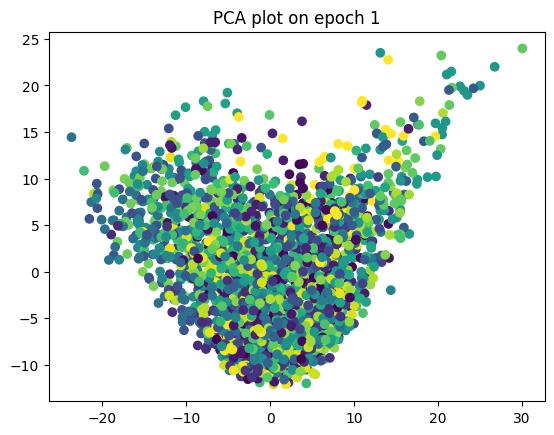

In [14]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os


EPOCHS = 100
plot_step = (1, 15, 27)
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    # plot
    if epoch in plot_step:
        with torch.no_grad():
            xs = None
            ys = None
            for batch_idx, (x, y) in enumerate(val_loader):
                x, y = x.to(device), y.to(device)
                output_x = last_layer(x)
                if xs is None:
                   xs = output_x.detach().cpu().numpy() # 防止梯度回傳; run on cpu only
                   ys = y.detach().cpu().numpy().flatten()

                  #  print(type(xs), xs.shape, type(ys), ys.shape, sep='\n')
                else:
                   output_x = output_x.detach().cpu().numpy()
                   y = y.detach().cpu().numpy().flatten()
                   xs = np.vstack((xs, output_x)) # 垂直堆疊
                   ys = np.concatenate((ys, y), axis=0) # 合併

                  #  print(type(output_x), output_x.shape, type(y), y.shape, type(xs), xs.shape, type(ys), ys.shape, sep='\n')
        xs = xs.reshape(xs.shape[0], -1)

        # PCA
        pca = PCA(n_components=2)
        pca_xs = pca.fit_transform(xs)
        plt.figure()
        plt.title(f"PCA plot on epoch {epoch}")
        plt.scatter(pca_xs[:, 0], pca_xs[:, 1], c=ys)
        plt.savefig(os.path.join("/content/drive/MyDrive/NTU_DLCV/p1_data", f"PCA_epoch{epoch}"), format='png')

        # TSNE
        tsne = TSNE(n_components=2, n_jobs=-1)
        tsne_x = tsne.fit_transform(xs)
        plt.figure()
        plt.title(f"TSNE plot on epoch {epoch}")
        plt.scatter(tsne_x[:, 0], tsne_x[:, 1], c=ys)
        plt.savefig(os.path.join("/content/drive/MyDrive/NTU_DLCV/p1_data", f"TSNE_epoch{epoch}"), format='png')




    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(optimizer.state_dict(), "/content/drive/MyDrive/NTU_DLCV/p1_data/CNN_best_optimizer.pth")
        torch.save(model.state_dict(), "/content/drive/MyDrive/NTU_DLCV/p1_data/CNN_best_model.pth")
        print("Model saved ~")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

In [ ]:
# import numpy as np
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import os

# num = 0
# xs = None
# for batch_idx, (x, y) in enumerate(val_loader):
#   if num == 2:
#     break
#   num += 1
#   print(x.shape)


#   x, y = x.to(device), y.to(device)
#   output_x = last_layer(x)
#   if xs is None:
#      xs = output_x.detach().cpu().numpy() # 防止梯度回傳
#      ys = y.detach().cpu().numpy().flatten()

#     #  print(type(xs), xs.shape, type(ys), ys.shape, sep='\n')
#   else:
#      output_x = output_x.detach().numpy()
#      y = y.detach().numpy().flatten()

#      xs = np.vstack((xs, output_x)) # 垂直堆疊
#      ys = np.concatenate((ys, y), axis=0) # 合併

#      print(type(output_x), output_x.shape, type(y), y.shape, type(xs), xs.shape, type(ys), ys.shape, sep='\n')

# xs = xs.reshape(xs.shape[0], -1)

# # plot PCA
# pca = PCA(n_components=2)
# pca_xs = pca.fit_transform(xs)
# plt.figure()
# plt.title(f"PCA plot on epoch {0}")
# plt.scatter(pca_xs[:, 0], pca_xs[:, 1], c=ys)

